# Fine-Tuning EfficientNet_v2_S for Image Classification

This notebook demonstrates a modern approach to fine-tuning EfficientNet_v2_S. The workflow includes:

- Data preprocessing and augmentation (using both standard and advanced techniques)
- Dynamic dataset handling for train, validation
- Fine-tuning the pretrained model with best practices (learning rate schedulers, checkpointing, etc.)
- Clean, well-documented code with improved markdown commentary


### 1. IMPORT LIBRARIES & SET RANDOM SEED


In [ ]:
# Import essential libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import json

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Function to normalize images
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


# Check TensorFlow version and available GPUs
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

print("GPU available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.19.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU available: True
Number of GPUs: 1


In [25]:
from tensorflow.keras import mixed_precision

# Enable mixed precision if GPU supports it (NVIDIA L4 does!)
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set.")
    except RuntimeError as e:
        print(e)

GPU memory growth set.


### 2. Data Acquisition & Organization

2.1 Folder Structure & Classes
Organize your dataset as follows:

```bash
Copy
Edit
dataset/
├── 1/       # e.g., rice leaf roller
├── 2/       # rice leaf caterpillar
│   └── ...
├── 3/       # rice stem borer
```

Also, maintain a classes.txt which maps folder numbers (or labels) to class names.

Explanation:
This organization is compatible with torchvision.datasets.ImageFolder, which automatically assigns labels based on folder names.


#### set the paths and parameters.


In [ ]:
# Set dataset directory
DATA_DIR = "dataset56/exact/dataset"

# Load dataset configuration
BATCH_SIZE = 32
IMG_SIZE = (384, 384)  # Reduced resolution for EfficientNetV2-S
SEED = 123
VALIDATION_SPLIT = 0.2

### 3. Load Datasets

    Since your data is not already split, load using `tf.keras.utils.image_dataset_from_directory `with  validation_split parameter.


In [28]:

# Load training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset="training"
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset="validation"
)

# Get class names
class_names = train_dataset.class_names
num_categories = len(class_names)
print("Classes:", class_names)
print("Number of categories:", num_categories)

Found 40154 files belonging to 56 classes.
Using 32124 files for training.
Found 40154 files belonging to 56 classes.
Using 8030 files for validation.
Classes: ['100_Rhytidodera_bowrinii_white', '102_Cicadellidae', '10_small_brown_plant_hopper', '11_rice_water_weevil', '12_rice_leafhopper', '13_grain_spreader_thrips', '14_rice_shell_pest', '15_grub', '16_mole_cricket', '17_wireworm', '18_white_margined_moth', '19_black_cutworm', '1_rice_leaf_roller', '20_large_cutworm', '21_yellow_cutworm', '22_red_spider', '23_corn_borer', '24_army_worm', '25_aphids', '26_Potosiabre_vitarsis', '27_peach_borer', '28_english_grain_aphid', '29_green_bug', '2_rice_leaf_caterpillar', '30_bird_cherry-oataphid', '31_wheat_blossom_midge', '32_penthaleus_major', '33_longlegged_spider_mite', '34_wheat_phloeothrips', '35_wheat_sawfly', '36_cerodonta_denticornis', '3_paddy_stem_maggot', '4_asiatic_rice_borer', '50_lytta_polita', '58_Apolygus_lucorum', '59_Limacodidae', '5_yellow_rice_borer', '6_rice_gall_midge', 

In [29]:
# Save the class names for future reference
with open('class_names1.pkl', 'wb') as f:
    pickle.dump(class_names, f)

print("Saved class names to class_names.pkl")

Saved class names to class_names.pkl


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Flip horizontally
    tf.keras.layers.RandomRotation(0.2),  # Rotate by ±20%
    tf.keras.layers.RandomZoom(0.2),  # Zoom in/out by 20%
    tf.keras.layers.RandomContrast(0.2),  # Change contrast by ±20%
    tf.keras.layers.RandomBrightness(0.2),  # Adjust brightness randomly
    tf.keras.layers.RandomTranslation(
        height_factor=0.1, width_factor=0.1)  # Shift images slightly
])

## Cell 4: Dataset Visualization (EDA) (Code)


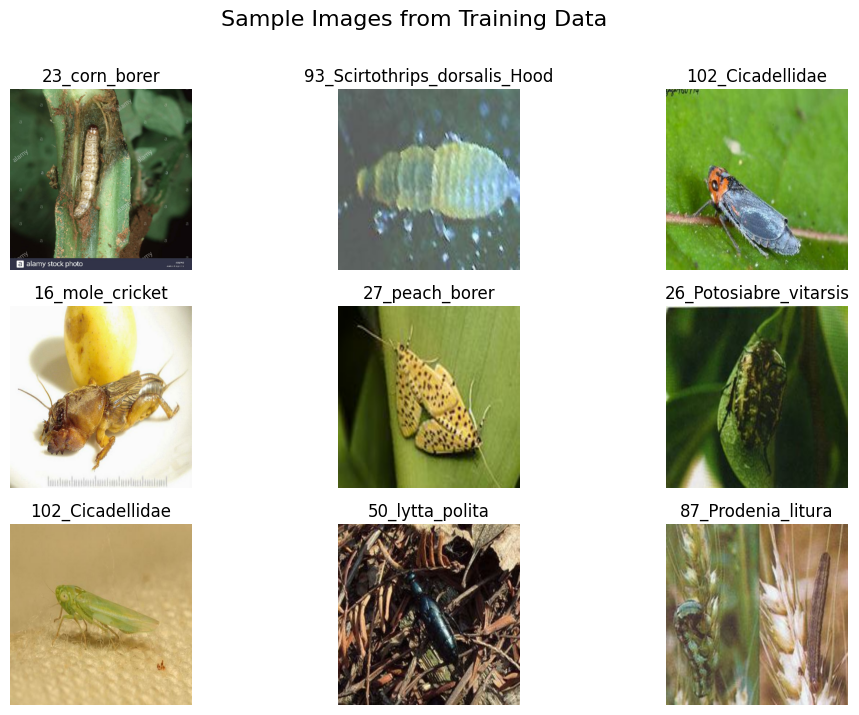

In [32]:
# -------------------------------
# 1️⃣ Display Sample Images
# -------------------------------
plt.figure(figsize=(12, 8))
for images, labels in train_dataset.take(1):
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i].numpy())
        plt.title(class_names[label_index])
        plt.axis("off")
plt.suptitle("Sample Images from Training Data", fontsize=16)
plt.show()

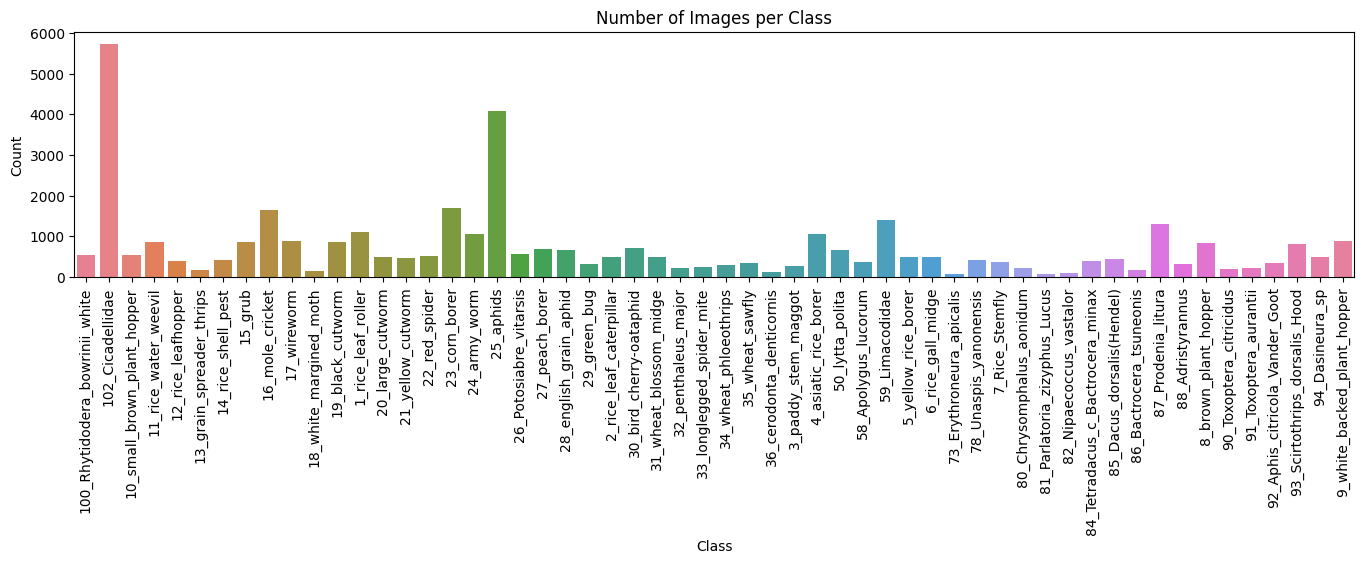

In [ ]:
# -------------------------------
# 2️⃣ Count Images Per Class (Fixed Version)
# -------------------------------
class_counts = {cls: len(os.listdir(os.path.join(DATA_DIR, cls)))
                for cls in class_names}
df_class_counts = pd.DataFrame(
    {"Class": list(class_counts.keys()), "Count": list(class_counts.values())})

# Plot class distribution
plt.figure(figsize=(14, 6))
sns.barplot(data=df_class_counts, x="Class", y="Count",
            hue="Class", legend=False, palette="husl")
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90, ha="center", fontsize=10)
plt.tight_layout(pad=2)  # Add padding to avoid label cut-off
plt.show()

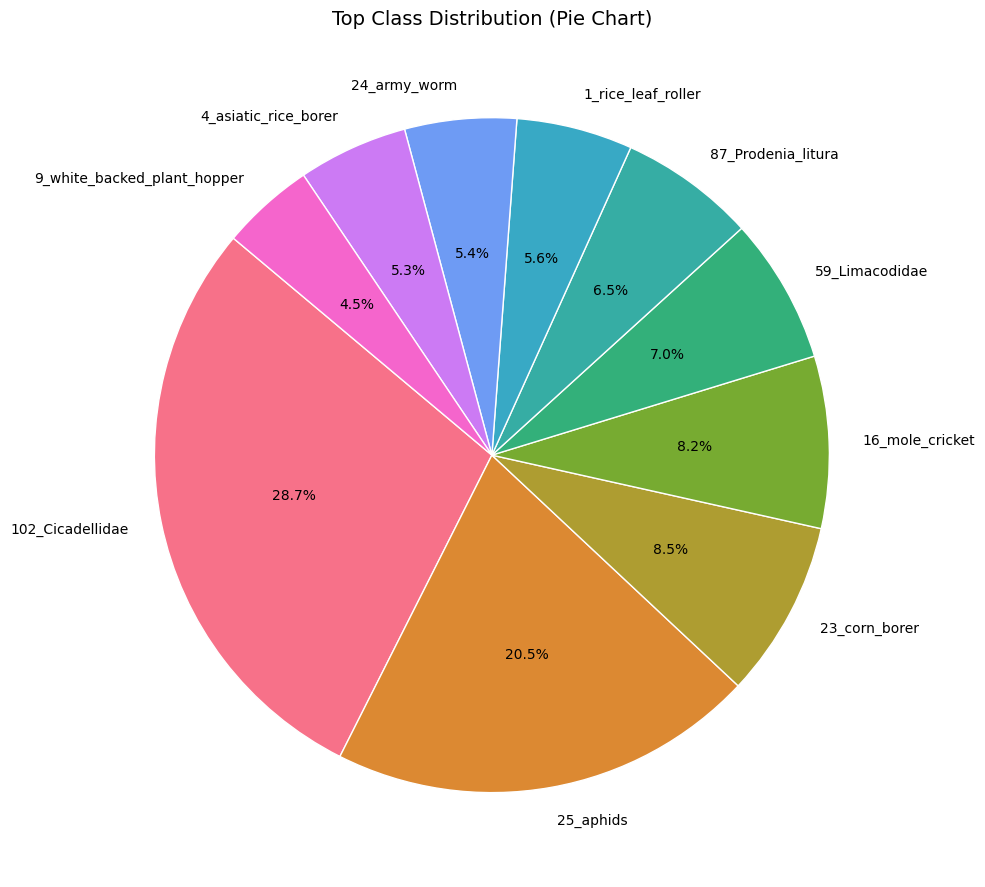

In [ ]:
# -------------------------------
# 3️⃣ Check Label Distribution (Pie Chart)
# -------------------------------
plt.figure(figsize=(10, 10))  # bigger figure
# Only show top classes to avoid overcrowding
top_n = 10
top_classes = df_class_counts.sort_values(
    by="Count", ascending=False).head(top_n)

# Create the pie chart
plt.pie(
    top_classes["Count"],
    labels=top_classes["Class"],
    autopct="%1.1f%%",
    colors=sns.color_palette("husl", len(top_classes)),
    startangle=140,          # Rotate start angle for better layout
    wedgeprops={'edgecolor': 'white'},  # Add white edges
    textprops={'fontsize': 10}          # Smaller font to avoid overlapping
)

plt.title("Top Class Distribution (Pie Chart)", fontsize=14)
plt.tight_layout()
plt.show()

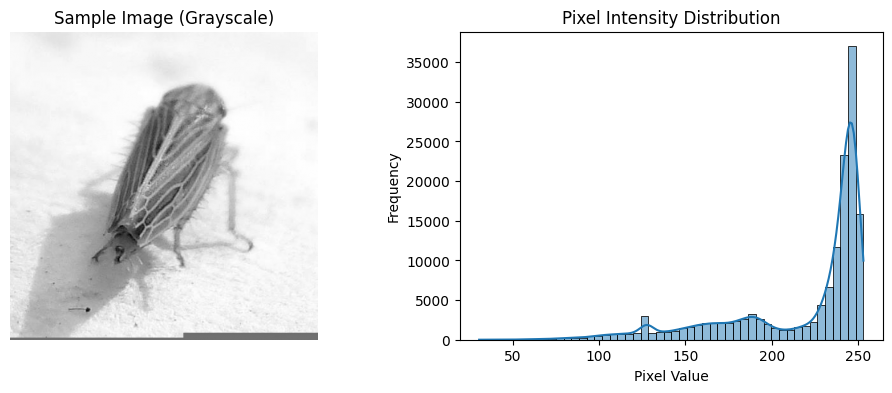

2025-04-07 10:33:43.136239: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# -------------------------------
# 5️⃣ Analyze Pixel Intensities
# -------------------------------
for images, _ in train_dataset.take(1):
    img = images[0].numpy().astype("uint8")
    gray_img = np.mean(img, axis=-1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(gray_img, cmap="gray")
    plt.title("Sample Image (Grayscale)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    sns.histplot(gray_img.ravel(), bins=50, kde=True)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:

# -------------------------------
# 6️⃣ Detect Duplicate Images
# -------------------------------
import hashlib


def get_hash(img_path):
    """ Returns hash for an image file """
    with open(img_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()


hashes = {}
duplicate_files = []

for cls in class_names:
    class_path = os.path.join(DATA_DIR, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img_hash = get_hash(img_path)

        if img_hash in hashes:
            duplicate_files.append(img_path)
        else:
            hashes[img_hash] = img_path

print(f"Number of duplicate images found: {len(duplicate_files)}")
if duplicate_files:
    print("Examples:", duplicate_files[:5])

Number of duplicate images found: 0


In [ ]:
# removing the duplicate images
for dup_path in duplicate_files:
    os.remove(dup_path)
    print(f"Deleted: {dup_path}")

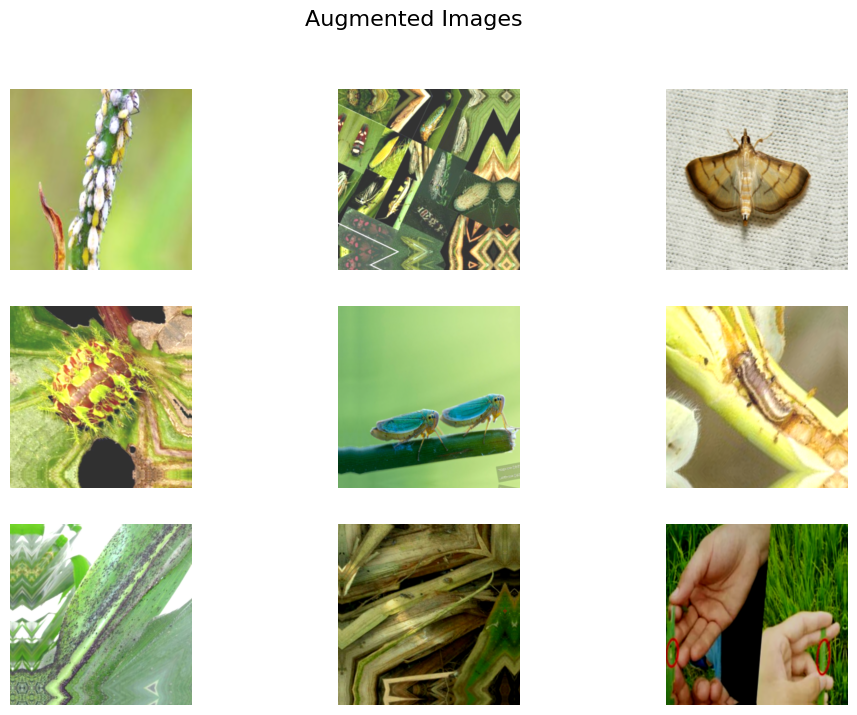

In [38]:
# -------------------------------
# 7️⃣ Visualize Augmented Images
# -------------------------------

plt.figure(figsize=(12, 8))
for images, _ in train_dataset.take(1):
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")

plt.suptitle("Augmented Images", fontsize=16)
plt.show()

In [ ]:
# -------------------------------
# 8️⃣ Check Mean & Standard Deviation of Pixel Values
# -------------------------------
pixel_values = []
for images, _ in train_dataset.take(5):
    pixel_values.append(images.numpy())

pixel_values = np.concatenate(pixel_values, axis=0)
means = np.mean(pixel_values, axis=(0, 1, 2))
stds = np.std(pixel_values, axis=(0, 1, 2))

print(f"Channel Means (R, G, B): {means}")
print(f"Channel Standard Deviations (R, G, B): {stds}")

Channel Means (R, G, B): [137.45938  145.5769   100.534584]
Channel Standard Deviations (R, G, B): [65.980446 62.30189  70.70715 ]


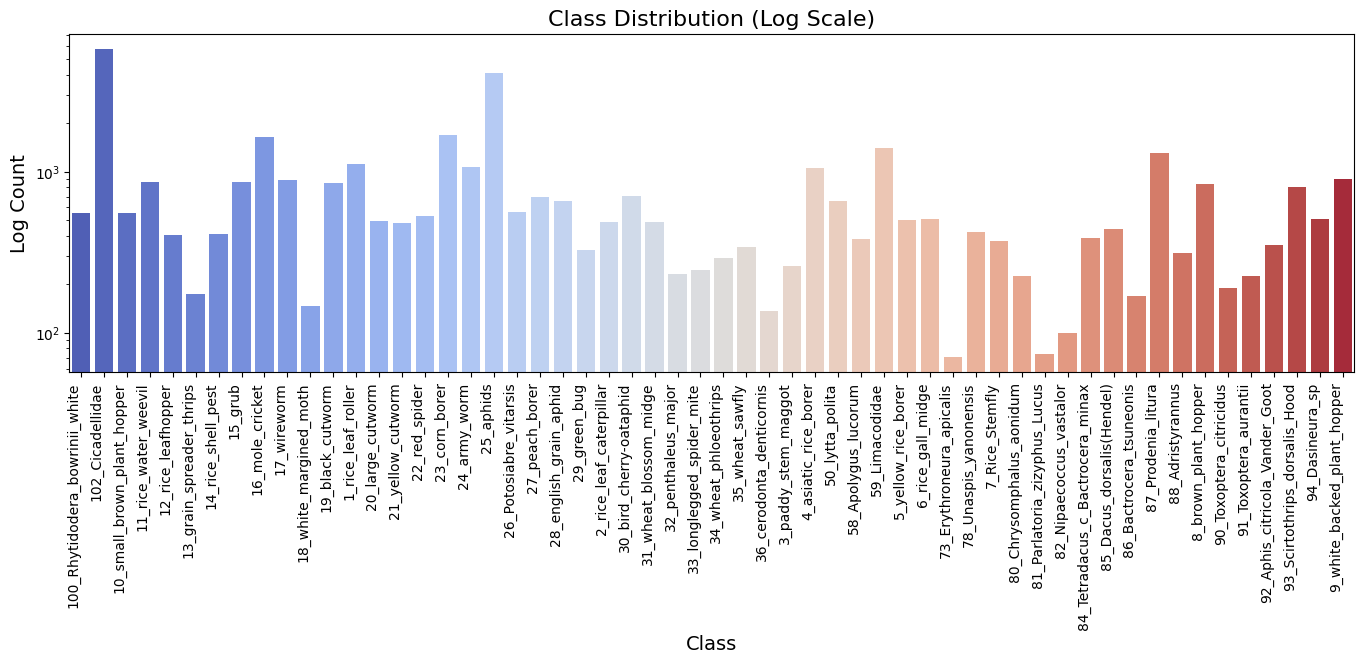

In [ ]:
# -------------------------------
# 9️⃣ Check Class Imbalance (Log Scale)
# -------------------------------
plt.figure(figsize=(14, 7))  # Bigger figure
sns.barplot(data=df_class_counts, x="Class", y="Count",
            hue="Class", legend=False, palette="coolwarm")
plt.yscale("log")
plt.title("Class Distribution (Log Scale)", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Log Count", fontsize=14)
plt.xticks(rotation=90, ha="right", fontsize=10)  # Rotate labels and align
plt.tight_layout(pad=2)  # Add extra padding
plt.show()

### 📌 1️⃣ Data Preprocessing & Augmentation (Pipeline Setup)

    Since we're using EfficientNetV2-S, it expects input images to be normalized and resized to (384, 384).

##### ✅ Key Steps:

    🔹 Resize images to (384, 384)
    🔹 Normalize pixel values [-1, 1]
    🔹 Apply augmentation during training
    🔹 Optimize dataset loading for efficiency


In [ ]:


# Function to preprocess images
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)  # Automatically scales [0,255] -> [-1,1]
    return image, label


# Apply preprocessing
train_dataset = train_dataset.map(
    preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(
    preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetching for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### 📌 2️⃣ Model Selection & Building

    Since we're using EfficientNetV2-S, you need to:

    🔹 Load EfficientNetV2-S with pretrained weights (using imagenet weight)
    🔹 Freeze base layers (for transfer learning)
    🔹 Add a custom classification head

Build the Model:


In [ ]:

# 1. Load EfficientNetV2-S pre-trained on ImageNet
base_model = EfficientNetV2S(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # 2. Freeze it (at first)

# 3. Build the model
inputs = Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)  # adding augmentation here
x = base_model(x, training=False)  # Use base model in inference mode
x = GlobalAveragePooling2D()(x)  # Pooling
x = Dropout(0.3)(x)              # Regularization
outputs = Dense(num_categories, activation="softmax")(
    x)  # Final layer for classes
model = Model(inputs, outputs)

model.summary()  # print model summary

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 12, 12, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        71,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,403,096 (77.83 MB)

 Trainable params: 71,736 (280.22 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

#### 3️⃣ Learning Rate Scheduler (ReduceLROnPlateau)

🔹 Adding a learning rate scheduler can reduce LR when the model stops improving.
🔹 Updated Callbacks


In [ ]:

# Optimizer with initial LR
optimizer = Adam(learning_rate=1e-4)

# Compile modelz
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    "best_plant_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

callbacks = [early_stop, checkpoint, lr_scheduler]

# Train model (initial training)
EPOCHS = 40
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/40
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2182 - loss: 3.4110
Epoch 1: val_accuracy improved from -inf to 0.43350, saving model to best_plant_model.keras
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 294s 272ms/step - accuracy: 0.2183 - loss: 3.4106 - val_accuracy: 0.4335 - val_loss: 2.4094 - learning_rate: 1.0000e-04
Epoch 2/40
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4183 - loss: 2.4262
Epoch 2: val_accuracy improved from 0.43350 to 0.48692, saving model to best_plant_model.keras
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 266s 265ms/step - accuracy: 0.4183 - loss: 2.4261 - val_accuracy: 0.4869 - val_loss: 2.0659 - learning_rate: 1.0000e-04
Epoch 3/40
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4637 - loss: 2.1521
Epoch 3: val_accuracy improved from 0.48692 to 0.51357, saving model to best_plant_model.keras
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 267s 266ms/step - accuracy: 0.4638 - loss: 2.1521 - val_accuracy: 0.5136 - val_loss: 1.8898 - learning_rate: 1.0000

#### 4️⃣ Plot training & validation accuracy values (before fine-tuning)


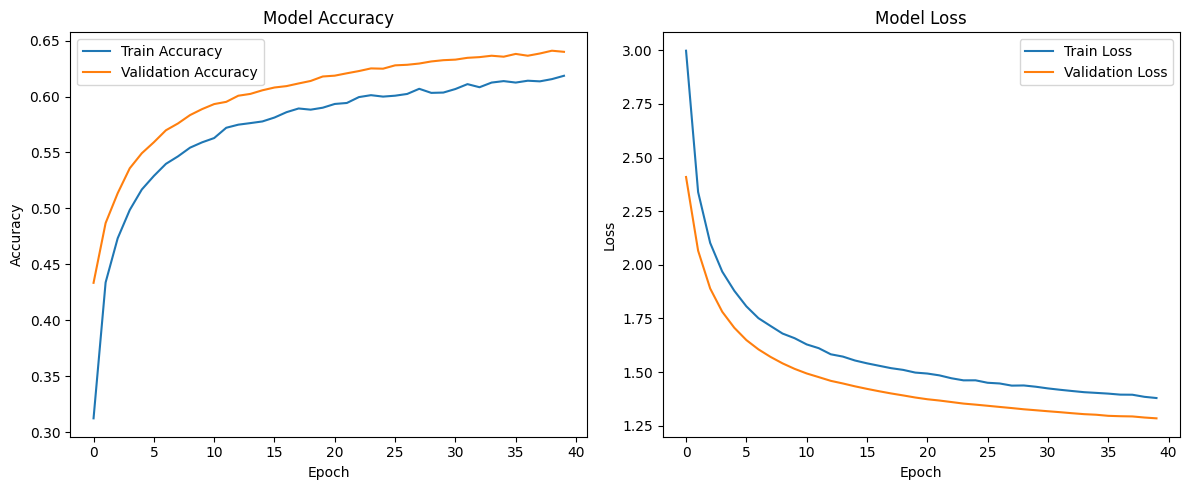

In [ ]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# saving history to a file for future reference
# Save the training history to a JSON file


# Convert the history.history dictionary to JSON and save to a file


with open("training_history.json", "w") as f:


    json.dump(history.history, f)

#### 📌 5️⃣ Fine-Tuning the Model

    🔹 Unfreeze some layers of the base model for fine-tuning (200 layers)
    🔹 Compile the model with a lower learning rate
    🔹 Train the model with early stopping and learning rate reduction callbacks


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Freeze the entire base model first
base_model.trainable = False

# Unfreeze the top 200 layers (except for BatchNormalization layers)
for layer in base_model.layers[-200:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


optimizer_fine = Adam(learning_rate=1e-6)
model.compile(
    optimizer=optimizer_fine,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    "efficientnetv2s_finetuned_finalhai-final.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-8,
    verbose=1
)
callbacks = [early_stop, checkpoint, lr_scheduler]

initial_epoch = 40
fine_tune_epochs = 20
total_epochs = initial_epoch + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    callbacks=callbacks
)

# final model saving
model.save("lastefficientnetv2s_finetuned_finalhai-final.keras")

Epoch 41/60
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6240 - loss: 1.3491
Epoch 41: val_accuracy improved from -inf to 0.65629, saving model to efficientnetv2s_finetuned_finalhai-final.keras
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 361s 328ms/step - accuracy: 0.6240 - loss: 1.3491 - val_accuracy: 0.6563 - val_loss: 1.2248 - learning_rate: 1.0000e-06
Epoch 42/60
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6355 - loss: 1.3146
Epoch 42: val_accuracy improved from 0.65629 to 0.66127, saving model to efficientnetv2s_finetuned_finalhai-final.keras
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 325s 323ms/step - accuracy: 0.6355 - loss: 1.3146 - val_accuracy: 0.6613 - val_loss: 1.2087 - learning_rate: 1.0000e-06
Epoch 43/60
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.6359 - loss: 1.2898
Epoch 43: val_accuracy improved from 0.66127 to 0.66401, saving model to efficientnetv2s_finetuned_finalhai-final.keras
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 325s 324ms/step - accuracy: 0.6359 - 

#### 5️⃣ Plot training & validation accuracy values (after fine-tuning)


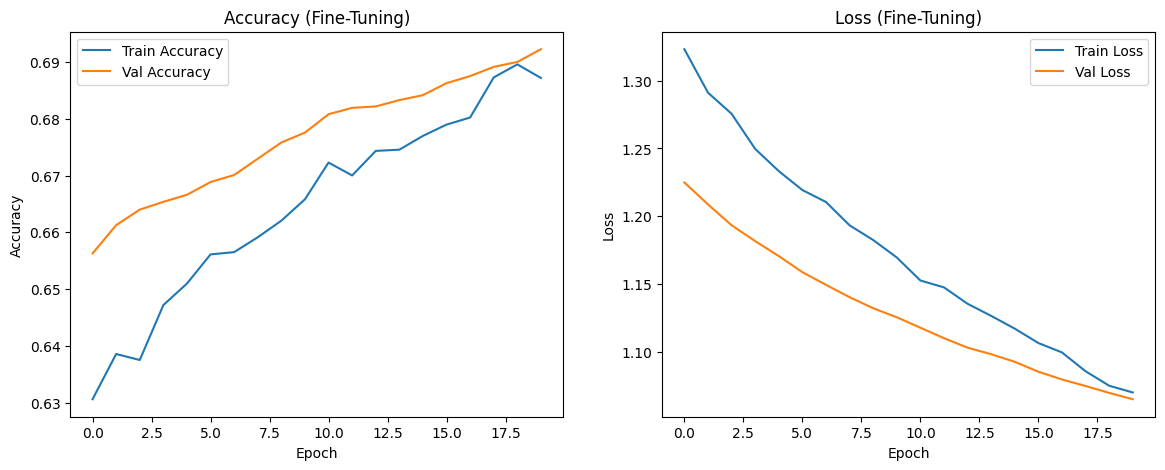

In [53]:
def plot_history(hist, title_suffix=""):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Loss' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_history(history_fine, " (Fine-Tuning)")

In [ ]:
# saving the fine-tuning history to a file
# Save the fine-tuning history to a JSON file

# Convert the history.history dictionary to JSON and save to a file



with open("training_history_fine.json", "w") as f:


    json.dump(history_fine.history, f)

#### 6️⃣ Evaluate the Model

    🔹 Evaluate the model on the test set
    🔹 Plot confusion matrix and classification report


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

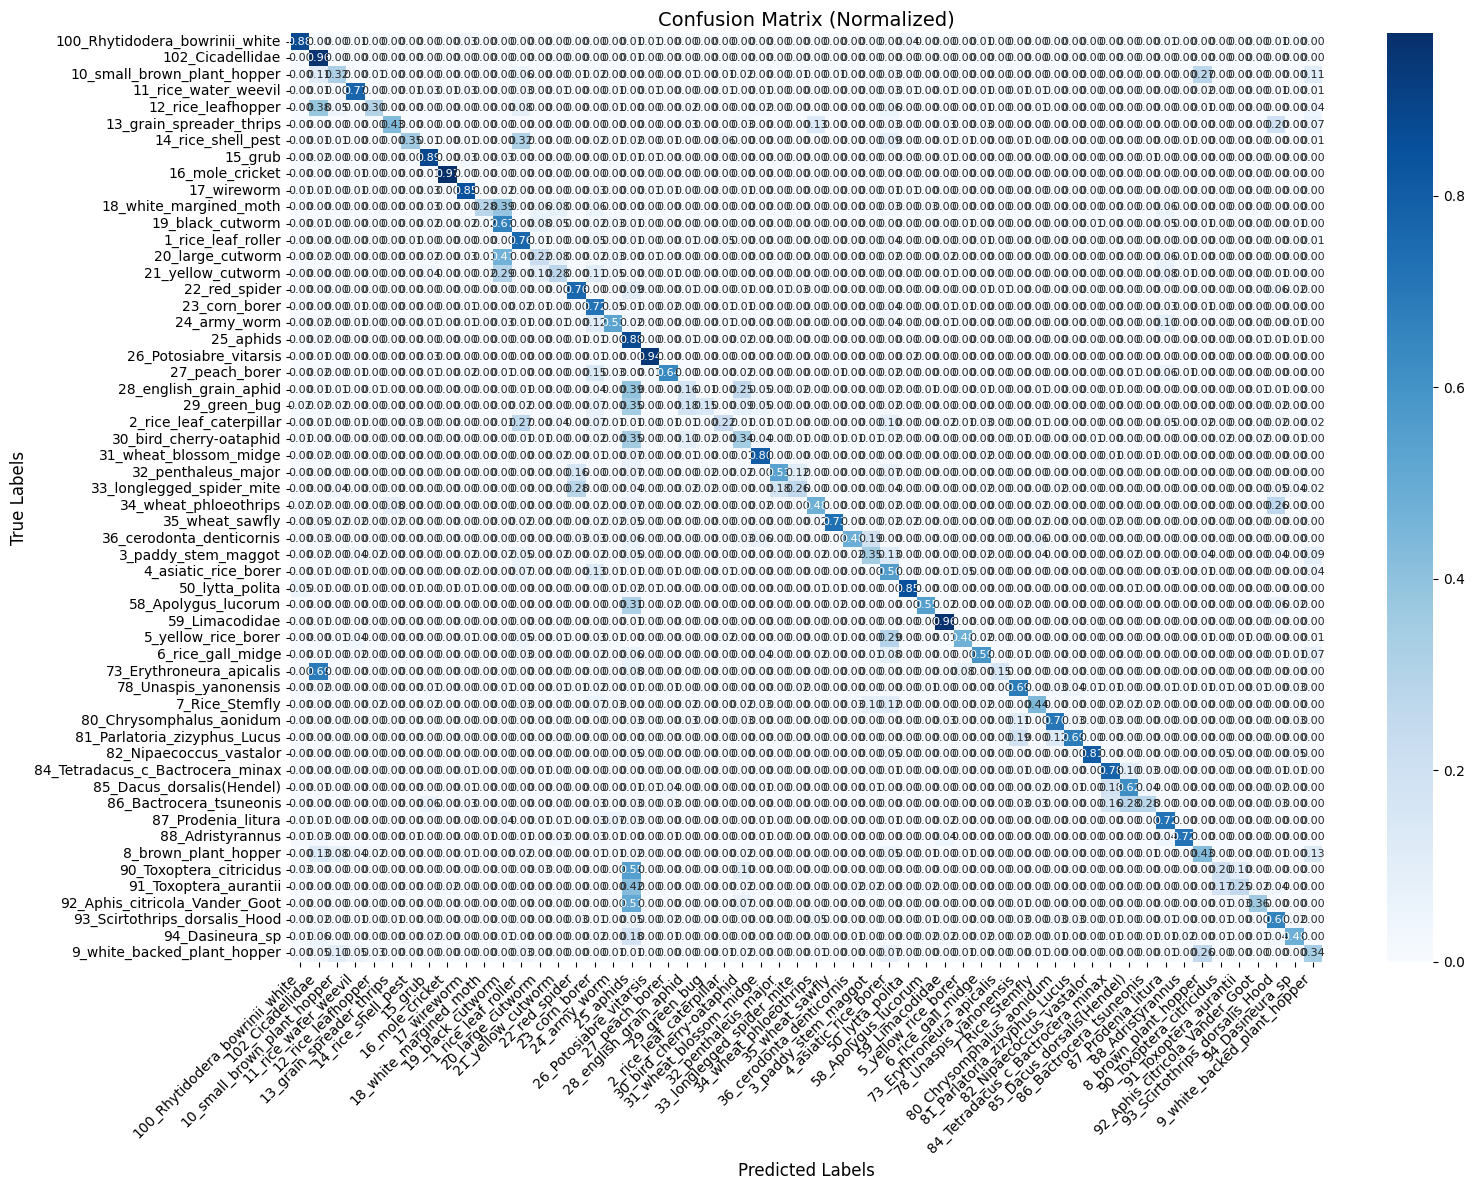

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


def evaluate_model(model, test_dataset, class_names):


    y_true, y_pred = [], []


    # Get predictions


    for images, labels in test_dataset:


        preds = model.predict(images)


        y_pred.extend(np.argmax(preds, axis=1))


        y_true.extend(np.argmax(labels.numpy(), axis=1))


    # Print Classification Report

    print(classification_report(y_true, y_pred, target_names=class_names))

    # Compute Confusion Matrix (Normalized)
    cm = confusion_matrix(y_true, y_pred, normalize="true")


    # Increase figure size
    plt.figure(figsize=(16, 12))

    # Plot confusion matrix

    ax = sns.heatmap(
        cm,


        annot=True,          # Show cell values


        fmt=".2f",


        cmap="Blues",


        xticklabels=class_names,


        yticklabels=class_names,


        annot_kws={"size": 8}  # Adjust annotation text size if needed
    )


    # Rotate and align tick labels on the x-axis


    plt.xticks(rotation=45, ha='right', fontsize=10)


    # Rotate tick labels on the y-axis (if desired)


    plt.yticks(rotation=0, fontsize=10)


    # Set labels and title


    plt.xlabel("Predicted Labels", fontsize=12)


    plt.ylabel("True Labels", fontsize=12)


    plt.title("Confusion Matrix (Normalized)", fontsize=14)


    plt.tight_layout()


    plt.show()



evaluate_model(model, validation_dataset, class_names)